In [3]:
from keras.datasets import mnist
import numpy as np
from skimage import io
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Conv2D, Dropout, Flatten, Dense, BatchNormalization, Reshape, UpSampling2D, Activation
from keras.optimizers import Adam, sgd
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from tqdm import tqdm
from IPython import display

(88800, 28, 28, 1)


<function matplotlib.pyplot.show>

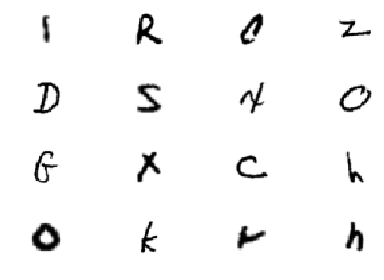

In [4]:
X_train = []
with open('input/emnist-letters-train.csv') as input_file:
    input_data = csv.reader(input_file,delimiter=',')
    for row in input_data:
        row.pop(0)
        X_train.append(np.array(list(map(float,row))).reshape(28,28,1).transpose(1,0,2))
X_train = np.array(X_train)
print(X_train.shape)
data_index = np.random.choice(X_train.shape[0],16)
samples = X_train[data_index,:,:,:]
for i in range(samples.shape[0]):
    plt.subplot(4,4,i+1)
    img = samples[i,:,:,0]
    plt.imshow(img, interpolation='nearest',cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show
        

In [5]:
X_train=(X_train.astype('float32')-128.0)/128.0
shp = X_train.shape[1:]
inidim = 100
dropout_rate = 0.3
opt = Adam(lr=2e-4,beta_1=0.5)
dopt = Adam(lr=2e-4,beta_1=0.5)

g_input = Input(shape=[inidim])
H = Dense(7*7*128, kernel_initializer='glorot_normal')(g_input)
H = LeakyReLU(0.2)(H)
H = Reshape( [7, 7, 128] )(H)
H = UpSampling2D(size=(2, 2))(H)
H = Conv2D(64, (5, 5), padding='same', kernel_initializer='glorot_uniform')(H)
H = LeakyReLU(0.2)(H)
H = UpSampling2D(size=(2, 2))(H)
H = Conv2D(1, (5, 5), padding='same', kernel_initializer='glorot_uniform')(H)
g_V = Activation('tanh')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

In [6]:
d_input = Input(shape=shp)
H = Conv2D(64, (5, 5), strides=(2, 2), padding= 'same')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Conv2D(128, (5, 5), strides=(2, 2), padding = 'same')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
d_V = Dense(2,activation='sigmoid')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='binary_crossentropy', optimizer=dopt)
discriminator.summary()
discriminator.trainable = False
gan_input = Input(shape=[inidim])
x = generator(gan_input)
gan_V = discriminator(x)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='binary_crossentropy', optimizer=opt)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
__________

In [7]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(7,7) ):
    noise = np.random.normal(0,1,size=[n_ex,inidim])
    generated_images = generator.predict(noise)
    
    
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img, cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
def plot_loss(losses):

    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.plot(losses["d"], label='discriminitive loss')
    plt.plot(losses["g"], label='generative loss')
    plt.legend()
    plt.show()

In [9]:
ntrain = 10000

trainidx = np.random.choice(X_train.shape[0], ntrain)
XT = X_train[trainidx,:,:,:]

noise_gen = np.random.normal(0,1,size=[XT.shape[0],inidim])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1
discriminator.trainable = True
discriminator.fit(X,y, epochs=1, batch_size=32)
y_hat = discriminator.predict(X)

Epoch 1/1


10752/20000 [===============>..............] - ETA: 9:58 - loss: 0.716 - ETA: 5:25 - loss: 0.698 - ETA: 3:54 - loss: 0.680 - ETA: 3:08 - loss: 0.663 - ETA: 2:41 - loss: 0.649 - ETA: 2:22 - loss: 0.637 - ETA: 2:09 - loss: 0.624 - ETA: 2:00 - loss: 0.610 - ETA: 1:53 - loss: 0.593 - ETA: 1:46 - loss: 0.575 - ETA: 1:41 - loss: 0.564 - ETA: 1:37 - loss: 0.549 - ETA: 1:34 - loss: 0.538 - ETA: 1:31 - loss: 0.517 - ETA: 1:28 - loss: 0.503 - ETA: 1:26 - loss: 0.490 - ETA: 1:23 - loss: 0.482 - ETA: 1:21 - loss: 0.468 - ETA: 1:20 - loss: 0.461 - ETA: 1:18 - loss: 0.453 - ETA: 1:17 - loss: 0.447 - ETA: 1:15 - loss: 0.439 - ETA: 1:14 - loss: 0.429 - ETA: 1:13 - loss: 0.419 - ETA: 1:12 - loss: 0.412 - ETA: 1:11 - loss: 0.403 - ETA: 1:10 - loss: 0.394 - ETA: 1:09 - loss: 0.389 - ETA: 1:09 - loss: 0.383 - ETA: 1:08 - loss: 0.377 - ETA: 1:07 - loss: 0.369 - ETA: 1:06 - loss: 0.362 - ETA: 1:06 - loss: 0.356 - ETA: 1:05 - loss: 0.349 - ETA: 1:05 - loss: 0.341 - ETA: 1:04 - loss: 0.335 - ETA: 1:04 - loss:

20000/20000 [==============================] - ETA: 25s - loss: 0.04 - ETA: 25s - loss: 0.04 - ETA: 25s - loss: 0.04 - ETA: 25s - loss: 0.03 - ETA: 25s - loss: 0.03 - ETA: 25s - loss: 0.03 - ETA: 25s - loss: 0.03 - ETA: 25s - loss: 0.03 - ETA: 25s - loss: 0.03 - ETA: 25s - loss: 0.03 - ETA: 25s - loss: 0.03 - ETA: 25s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 23s - loss: 0.03 - ETA: 23s - loss: 0.03 - ETA: 23s - loss: 0.03 - ETA: 23s - loss: 0.03 - ETA: 23s - loss: 0.03 - ETA: 23s - loss: 0.03 - ETA: 23s - loss: 0.03 - ETA: 23s - loss: 0.03 - ETA: 23s - loss: 0.03 - ETA: 23s - loss: 0.03 - ETA: 22s - loss: 0.03 - ETA: 22s - loss: 0.03 - ETA: 22s - loss: 0.03 - ETA: 22s - loss: 0.03 - ETA: 22s - loss: 0.03 - ETA: 22s - loss: 0.03 - ETA: 22s - loss: 

In [10]:
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot))

Accuracy: 100.00 pct (20000 of 20000) right


In [11]:
losses = {"d":[], "g":[]}

def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):
        image_batch = X_train[np.random.choice(X_train.shape[0],size=BATCH_SIZE),:,:,:]
        noise_gen = np.random.normal(0,1,size=[BATCH_SIZE,inidim])
        generated_images = generator.predict(noise_gen)
    
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
        
        discriminator.trainable = False
        for i in range(1):
            noise_tr = np.random.normal(0,1,size=[BATCH_SIZE,inidim])
            y2 = np.zeros([BATCH_SIZE,2])
            y2[:,1] = 1
            g_loss = GAN.train_on_batch(noise_tr, y2 )

        losses["g"].append(g_loss)
        
        if e%plt_frq==0:
            plot_loss(losses)
            plot_gen()

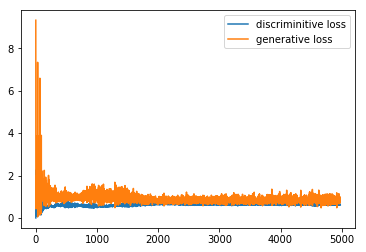

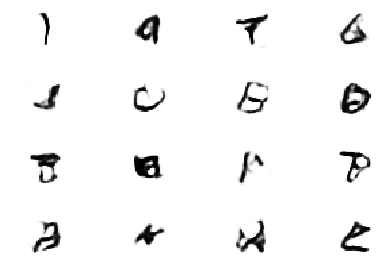

100%|████████████████████████████████████████████████████| 5000/5000 [5:28:21<00:00,  3.94s/it]


In [12]:
train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=128)

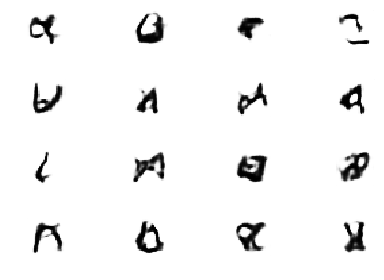

In [13]:
plot_gen()

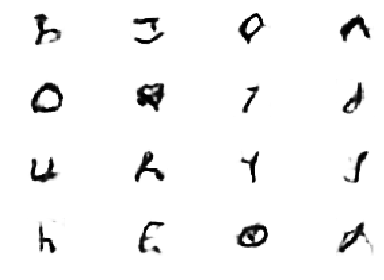

In [14]:
plot_gen()

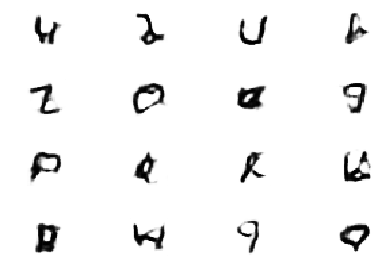

In [15]:
plot_gen()